# pyDGSA tutorial (Short version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np

# Load model parameters
parameters = np.load("tests/data/analytic_params.npy")
responses = np.empty((parameters.shape[0], 4), dtype="float64")

# Construct model responses
responses[:, 0] = parameters[:, 4]
responses[:, 1] = np.abs(parameters[:, 2] * parameters[:, 3] - 1)
responses[:, 2] = np.sqrt(np.minimum(parameters[:, 2], parameters[:, 3]))
responses[:, 3] = np.sqrt(parameters[:, 4])

In [2]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric="euclidean")
distances = squareform(distances)

In [3]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

In [4]:
# Calculate mean sensitivity across clusters
from pyDGSA.dgsa import dgsa

sens = dgsa(parameters, labels, parameter_names=["v", "w", "x", "y", "z"], confidence=True)
print(sens)

  0%|          | 0/3000 [00:00<?, ?it/s]

   sensitivity  confidence
v     0.656839    0.432701
w     0.480339    0.325199
x     1.961295    1.097348
y     1.804755    1.047279
z     4.196472    2.540091


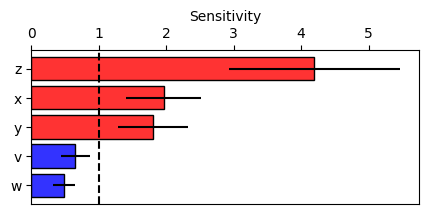

In [5]:
# Generate a pareto plot of the results
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(sens, confidence=True)